### Learn all based on counts

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import sys

import time
import random
import distance
import random
import dynet as dy
import _dynet
import json
import time
from datetime import datetime

np.set_printoptions(threshold=np.nan)
dyparams = dy.DynetParams()
dyparams.set_mem(4096)

In [2]:
df = pd.read_csv('finale.txt', delimiter='\t', header=None)
df.columns = ['word1', 'word2', 'counts']

In [3]:
new_df = df[df.word1 != df.word2]

In [4]:
new_df.head()

,word1,word2,counts
0,20/400,betimol,125
1,fusidic acid,ondansetron,101
2,right ventricular hypertrophy,emotional distress,156
3,methylcellulose,seroquel,129
4,mannitol,patient date of birth,1046


In [5]:
def read_singleton_dict(dictionary_dir):
    dic, count, unigram = {}, 0, []
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[line[0].strip()] = [int(line[1].strip()), count]
            unigram.append(count)
            count += 1
        return (dic, unigram)

In [6]:
path = '2_Singleton_Frequency_Counts/singlets_concepts_perBin_1d.txt'
singleton, unigram_table = read_singleton_dict(path)

In [7]:
def read_cofreq_dict(dictionary_dir):
    dic = {}
    with open(dictionary_dir, 'r') as file:
        lines = file.readlines()
        for row in lines:
            line = row.split('\t')
            dic[(line[0].strip(), line[1].strip()) ] = int(line[2].strip())
        return dic

In [8]:
path = '1_Cofrequency_Counts/cofreqs_concepts_perBin_1d.txt'
cofreq = read_cofreq_dict(path)

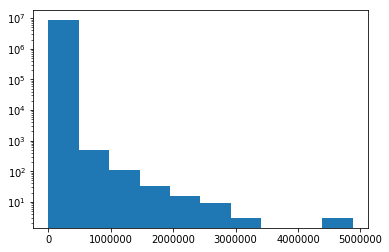

In [9]:
from matplotlib import pyplot as plt

plt.hist(cofreq.values(), log=True)
plt.show()

In [10]:
def build_training_data():
    training_data = []
    for sent_a, sent_b in cofreq.keys():
        counts = cofreq[(sent_a, sent_b)]
#         if sent_a != sent_b:
        if (sent_a in singleton) and (sent_b in singleton):
            indexA = singleton[sent_a][1]
            indexB = singleton[sent_b][1]
            training_data.append([indexA, indexB])
#             [training_data.append([indexA, indexB]) for _ in range(int(np.log(counts)))]#range(min(counts, min(counts, 10000)))]
    return training_data

In [11]:
training_data = build_training_data()

In [12]:
def is_valid_cuis(unigram, indexs, positive_cui):
    for i in indexs:
        if (unigram[i] == positive_cui[0]) or (unigram[i] == positive_cui[1]) :
            return False
    return True

def get_negative_sample_cuis(unigram, sample_size, positive_cui):
    population = range(len(unigram))
    indexs = random.sample(population, sample_size)
    cuis = []
    while not is_valid_cuis(unigram, indexs, positive_cui):
        indexs = random.sample(population, sample_size)
    for i in indexs:
        cuis.append(unigram[i])
    return cuis

def insert_negative_sample(training_data, unigram, sample_size):
    for i in range(len(training_data)):
        # drop the old negative samples first
        word_list = training_data[i][:2]
        negative_samples = get_negative_sample_cuis(unigram, sample_size, word_list)
        training_data[i] = word_list + negative_samples

### Helper

In [13]:
def get_duration(start_time):
    end_time = datetime.now()
    return 'Duration: {}'.format(end_time - start_time)

### Dynet Network

In [14]:
# create a class encapsulating the network
class OurNetwork(object):
    def __init__(self, pc, dictionary):
        self.dict_size = len(dictionary)
        self.lookup_hidden = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        self.lookup_output = pc.add_lookup_parameters((self.dict_size, word_vector_size))
        print('Create Network with word vector size: ' + str(word_vector_size))

    def __call__(self, inputs):
        # inputs: [input word, observed word, negative sample 1, negative sample 2...]
        input_word = inputs[0]
        observed_word = inputs[1]
        
        loss = dy.log(dy.logistic(self.get_dot_product(input_word, observed_word)))
        for negative_sample in inputs[2:]:
            loss += dy.log(dy.logistic(-self.get_dot_product(input_word, negative_sample)))
        return -loss
    
    def get_dot_product(self, wordA, wordB):
        return dy.dot_product(self.lookup_hidden[wordA], self.lookup_output[wordB])
    
    def create_network_return_loss(self, inputs):
        dy.renew_cg()
        return self(inputs)

In [15]:
word_vector_size = 100
m = dy.ParameterCollection()

# create network
network = OurNetwork(m, singleton)

Create Network with word vector size: 100


In [16]:
# create trainer
trainer = dy.SimpleSGDTrainer(m)

In [17]:
negative_sample_size = 2
print('Start training with negative sample size: ' + str(negative_sample_size))

total_loss = 0
global seen_instances, epoch
ts = int(time.time())
epoch = 1

Start training with negative sample size: 2


In [18]:
def run_iteration(it_num):
    seen_instances, total_loss = 0, 0
    start_time = datetime.now()
    print('Running Iteration: ' + str(it_num))
    
    np.random.shuffle(training_data)
    print('Finish shuffling data ' + get_duration(start_time))
    
    insert_negative_sample(training_data, unigram_table, negative_sample_size)
    print('Finish inserting negative samples' + get_duration(start_time))
    
    for word_list in training_data:
        seen_instances += 1
        loss = network.create_network_return_loss(word_list)
        total_loss += loss.value()
        loss.backward()
        trainer.update()
        if seen_instances > 1 and seen_instances % 10000 == 0:
            print("average loss is: " + str(total_loss / seen_instances) + ' '\
                  + get_duration(start_time) + ' ' + str(seen_instances))

In [20]:
seen_instances = 0
while True:
    run_iteration(epoch)
    epoch += 1
    if epoch == 11:
        save_embedding(network.lookup_hidden, ts-1)
    else:save_embedding(network.lookup_hidden, ts)

Running Iteration: 1
Finish shuffling data Duration: 0:00:01.864397
Finish inserting negative samplesDuration: 0:00:45.114801
average loss is: 2.084297595894337 Duration: 0:00:45.386773 10000
average loss is: 2.083462083762884 Duration: 0:00:45.620802 20000
average loss is: 2.0834638889869055 Duration: 0:00:45.856274 30000
average loss is: 2.0835974517673255 Duration: 0:00:46.089882 40000
average loss is: 2.083472308046818 Duration: 0:00:46.324377 50000
average loss is: 2.083594534877936 Duration: 0:00:46.557688 60000
average loss is: 2.0835599781223704 Duration: 0:00:46.815690 70000
average loss is: 2.0835377164244653 Duration: 0:00:47.046729 80000
average loss is: 2.083547611712085 Duration: 0:00:47.284252 90000
average loss is: 2.0834825786066054 Duration: 0:00:47.522231 100000
average loss is: 2.083640194352107 Duration: 0:00:47.756753 110000
average loss is: 2.083699016965429 Duration: 0:00:47.991231 120000
average loss is: 2.083618745329747 Duration: 0:00:48.242232 130000
average

average loss is: 1.5633802639092915 Duration: 0:01:14.221581 1220000
average loss is: 1.5598004226585003 Duration: 0:01:14.453108 1230000
average loss is: 1.5561945500543626 Duration: 0:01:14.690080 1240000
average loss is: 1.5528723984366 Duration: 0:01:14.922080 1250000
average loss is: 1.5494626085639591 Duration: 0:01:15.156109 1260000
average loss is: 1.546029805872249 Duration: 0:01:15.412642 1270000
average loss is: 1.542802694031065 Duration: 0:01:15.643699 1280000
average loss is: 1.539494638924006 Duration: 0:01:15.878735 1290000
average loss is: 1.5362265045208756 Duration: 0:01:16.112233 1300000
average loss is: 1.533042974881127 Duration: 0:01:16.346703 1310000
average loss is: 1.5299733344349897 Duration: 0:01:16.578733 1320000
average loss is: 1.5267332243387286 Duration: 0:01:16.830736 1330000
average loss is: 1.523620431123204 Duration: 0:01:17.063226 1340000
average loss is: 1.5205613535553892 Duration: 0:01:17.296226 1350000
average loss is: 1.517536287590931 Duratio

average loss is: 1.3097117622245096 Duration: 0:01:42.856809 2430000
average loss is: 1.3084754724621501 Duration: 0:01:43.090714 2440000
average loss is: 1.307226871691445 Duration: 0:01:43.310506 2450000
average loss is: 1.3059380154548803 Duration: 0:01:43.552513 2460000
average loss is: 1.3047445645857594 Duration: 0:01:43.776083 2470000
average loss is: 1.3034876065480687 Duration: 0:01:43.988155 2480000
average loss is: 1.3022617534034082 Duration: 0:01:44.204422 2490000
average loss is: 1.300975449439943 Duration: 0:01:44.427708 2500000
average loss is: 1.2997711996147627 Duration: 0:01:44.634453 2510000
average loss is: 1.298622697623951 Duration: 0:01:44.899930 2520000
average loss is: 1.2974526565127138 Duration: 0:01:45.132950 2530000
average loss is: 1.296302216493758 Duration: 0:01:45.359817 2540000
average loss is: 1.2951460898895166 Duration: 0:01:45.592840 2550000
average loss is: 1.293986206130007 Duration: 0:01:45.813748 2560000
average loss is: 1.292875799839667 Dura

average loss is: 1.2034355579700138 Duration: 0:02:11.057400 3620000
average loss is: 1.2028321660215828 Duration: 0:02:11.284930 3630000
average loss is: 1.2021761318913606 Duration: 0:02:11.510430 3640000
average loss is: 1.2015296349649376 Duration: 0:02:11.742403 3650000
average loss is: 1.2008535422935314 Duration: 0:02:11.994433 3660000
average loss is: 1.2002174969343857 Duration: 0:02:12.221424 3670000
average loss is: 1.1995634807015765 Duration: 0:02:12.451424 3680000
average loss is: 1.1990071448750002 Duration: 0:02:12.676432 3690000
average loss is: 1.1983623140239905 Duration: 0:02:12.910985 3700000
average loss is: 1.1977204360835894 Duration: 0:02:13.144033 3710000
average loss is: 1.1971136276905048 Duration: 0:02:13.397036 3720000
average loss is: 1.196486176298182 Duration: 0:02:13.625564 3730000
average loss is: 1.1958924247572786 Duration: 0:02:13.855069 3740000
average loss is: 1.195303798559798 Duration: 0:02:14.084558 3750000
average loss is: 1.194701106240782 D

average loss is: 1.1428698726964186 Duration: 0:02:38.654943 4820000
average loss is: 1.142482607751222 Duration: 0:02:38.882432 4830000
average loss is: 1.1420875898801832 Duration: 0:02:39.105433 4840000
average loss is: 1.1416906005606227 Duration: 0:02:39.327934 4850000
average loss is: 1.1412959961597435 Duration: 0:02:39.552443 4860000
average loss is: 1.1409330437050684 Duration: 0:02:39.792435 4870000
average loss is: 1.1405226905560286 Duration: 0:02:40.017910 4880000
average loss is: 1.1401408527894472 Duration: 0:02:40.242412 4890000
average loss is: 1.1397545028421574 Duration: 0:02:40.465913 4900000
average loss is: 1.1393699818958352 Duration: 0:02:40.691440 4910000
average loss is: 1.139001976857366 Duration: 0:02:40.912914 4920000
average loss is: 1.1386113616436042 Duration: 0:02:41.164410 4930000
average loss is: 1.1382404398376949 Duration: 0:02:41.389934 4940000
average loss is: 1.137871341152777 Duration: 0:02:41.614934 4950000
average loss is: 1.1374680551927838 D

average loss is: 1.1035053688199 Duration: 0:03:05.677517 6010000
average loss is: 1.1032260261435887 Duration: 0:03:05.903046 6020000
average loss is: 1.1029694597000719 Duration: 0:03:06.127061 6030000
average loss is: 1.1026997525571658 Duration: 0:03:06.355569 6040000
average loss is: 1.1024392480592855 Duration: 0:03:06.583078 6050000
average loss is: 1.1021913187954833 Duration: 0:03:06.808052 6060000
average loss is: 1.1019479060005763 Duration: 0:03:07.041559 6070000
average loss is: 1.1016737495379898 Duration: 0:03:07.264092 6080000
average loss is: 1.1014097717121683 Duration: 0:03:07.485575 6090000
average loss is: 1.1011536751641438 Duration: 0:03:07.705580 6100000
average loss is: 1.100881439996801 Duration: 0:03:07.927110 6110000
average loss is: 1.1005899493436628 Duration: 0:03:08.150626 6120000
average loss is: 1.1003212835982226 Duration: 0:03:08.378102 6130000
average loss is: 1.1000372405848187 Duration: 0:03:08.609610 6140000
average loss is: 1.099768993973735 Dur

average loss is: 1.0751648136089536 Duration: 0:03:33.024368 7220000
average loss is: 1.074934560479589 Duration: 0:03:33.243375 7230000
average loss is: 1.074743913929611 Duration: 0:03:33.468388 7240000
average loss is: 1.074540858205281 Duration: 0:03:33.689898 7250000
average loss is: 1.0743647811239865 Duration: 0:03:33.921377 7260000
average loss is: 1.0741617809639359 Duration: 0:03:34.141882 7270000
average loss is: 1.0739593701185113 Duration: 0:03:34.365624 7280000
average loss is: 1.0737705008702312 Duration: 0:03:34.589151 7290000
average loss is: 1.073570482195434 Duration: 0:03:34.811137 7300000
average loss is: 1.073374339708825 Duration: 0:03:35.034838 7310000
average loss is: 1.0731470111452965 Duration: 0:03:35.255351 7320000
average loss is: 1.0729694811650377 Duration: 0:03:35.499327 7330000
average loss is: 1.0727795513119414 Duration: 0:03:35.718863 7340000
average loss is: 1.072608961232932 Duration: 0:03:35.942891 7350000
average loss is: 1.07242336796009 Durati

average loss is: 1.0548248717026258 Duration: 0:03:59.615129 8410000
average loss is: 1.0546720799057827 Duration: 0:03:59.842622 8420000
average loss is: 1.0545124190840516 Duration: 0:04:00.059078 8430000
average loss is: 1.0543825492172776 Duration: 0:04:00.294394 8440000
average loss is: 1.0542211051097157 Duration: 0:04:00.517087 8450000
average loss is: 1.0540864829786425 Duration: 0:04:00.742273 8460000
average loss is: 1.053927841542845 Duration: 0:04:00.959205 8470000
average loss is: 1.0537638645123029 Duration: 0:04:01.234644 8480000
average loss is: 1.0536130785591422 Duration: 0:04:01.456430 8490000
average loss is: 1.0534592295237617 Duration: 0:04:01.686045 8500000
average loss is: 1.05333417212678 Duration: 0:04:01.904452 8510000
average loss is: 1.0531846316866162 Duration: 0:04:02.136986 8520000
average loss is: 1.0530564398196576 Duration: 0:04:02.357490 8530000
average loss is: 1.0529091928322865 Duration: 0:04:02.580232 8540000
average loss is: 1.05276484596898 Dur

KeyboardInterrupt: 

In [19]:
def get_embedding_dir(ts):
    base_dir = 'embeddings/'
    config_dir = base_dir + str(ts) + '_config' + '.txt'
    embedding_dir = base_dir + str(ts) + '_embedding' + '.txt'
    
    config = {'bin_category': 'singlets_concepts_perBin_1d.txt',
              'epoch': epoch,
              'log': 'nolog',
              'training_data_size': len(training_data), 
              'negative_sample_size': negative_sample_size,
              'word_vector_size': word_vector_size,
              'embedding_dir': embedding_dir}
    
    with open(config_dir, 'w') as f:
        json.dump(config, f)
    return embedding_dir

def save_embedding(lookup, ts):
    embedding_dir = get_embedding_dir(ts)
    embedding_file = open(embedding_dir, "w")
    dictionary_keys = list(singleton.keys())
    line = str(len(dictionary_keys)) + ' ' + str(word_vector_size) + '\n'
    embedding_file.write(line)
    
    for i in dictionary_keys:
        cui, cui_index = i, singleton[i][1]
        weights = dy.lookup(lookup, cui_index).value()
        line = str(cui) + ' ' + ' '.join(map(str, weights)) + '\n'
        embedding_file.write(line)
    embedding_file.close()
    print('Embedding file saved at ' + embedding_dir)

In [21]:
save_embedding(network.lookup_hidden, ts)

Embedding file saved at embeddings/1524615647_embedding.txt
